# Clase 5: Reducción de dimensionalidad

## Malidición de la dimensionalidad

Ejemplo: Distancia promedio entre puntos en un espacio unitarios en K dimensiones.

In [1]:
import numpy as np

def getRandomPoint(d=2):
  return np.random.uniform(low=0.0, high=1.0, size= d)

def getDistanceBetweenRandomPoints(d=2):
  p1 = getRandomPoint(d)
  p2 = getRandomPoint(d)
  sqs = [(x-y)**2 for x,y in zip(p1,p2)]
  return np.sqrt(np.sum(sqs))

D = [2,4,8,16,32,1024, 2048, 5000, 10000, 100000]
print("Dimensiones\tDistancia promedio")
for d in D:
  dist = np.array([])
  for i in range(0,100):
    dist = np.append(dist, getDistanceBetweenRandomPoints(d))
  print(d, "\t\t", np.mean(dist))


Dimensiones	Distancia promedio
2 		 0.5049277751561454
4 		 0.7454821702544534
8 		 1.088658665205108
16 		 1.5949826627864199
32 		 2.266414917328664
1024 		 13.017945981345445
2048 		 18.509937229049346
5000 		 28.892064744830417
10000 		 40.86047684493044
100000 		 129.08895946275777


## Análisis de Componentes Principales

### 1. PCA con `scikit-learn`: Conjunto de datos USArrests

Versión original en R: James, G., Witten, D., Hastie, T., & Tibishirani, R. (2013). An Introduction to Statistical Learning. Springer Texts in Statistics.

Adaptación original a Python por J. Warmenhoven, actualizada por R. Jordan Crouser.


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
plt.style.use('ggplot')

In [3]:
!wget 'https://drive.google.com/uc?export=download&id=1xKSc7x4ZjcmL-x_w2yGRUAVNdHcWgLcD' -O USArrests.csv

--2020-10-20 23:33:55--  https://drive.google.com/uc?export=download&id=1xKSc7x4ZjcmL-x_w2yGRUAVNdHcWgLcD
Resolving drive.google.com (drive.google.com)... 172.217.214.100, 172.217.214.102, 172.217.214.101, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.100|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0s-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grl5i18c2i6mp84i6rfgp93c606qen43/1603236825000/13307417494834192396/*/1xKSc7x4ZjcmL-x_w2yGRUAVNdHcWgLcD?e=download [following]
--2020-10-20 23:33:55--  https://doc-0s-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/grl5i18c2i6mp84i6rfgp93c606qen43/1603236825000/13307417494834192396/*/1xKSc7x4ZjcmL-x_w2yGRUAVNdHcWgLcD?e=download
Resolving doc-0s-3c-docs.googleusercontent.com (doc-0s-3c-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to doc-0s-3c-docs.googleusercontent.com (do

En este ejercicio realizamos Análisis de Componentes Principales (PCA) en el conjunto de datos `USArrests`. Para cada uno de los 50 estados de los EE.UU., el conjunto de datos contiene el número de arrestos por cada 100,000 residentes para cada uno de tres crímenes: Asalto (`Assault`), Asesinato (`Murder`) y Violación (`Rape`). También se registra la variable `UrbanPop` (porcentaje de la población en cada estado que vive en las áreas urbanas).

Las filas del conjunto de datos contienen los 50 estados, en orden alfabético.

In [4]:
df = pd.read_csv('USArrests.csv', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, Alabama to Wyoming
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Murder    50 non-null     float64
 1   Assault   50 non-null     int64  
 2   UrbanPop  50 non-null     int64  
 3   Rape      50 non-null     float64
dtypes: float64(2), int64(2)
memory usage: 2.0+ KB


In [5]:
df.head() 
# nota que son 4 y que tomaremos a cada feature/columna como un componente
# no seleccionaremos alguno ahora para el PCA

,Murder,Assault,UrbanPop,Rape
Alabama,13.2,236,58,21.2
Alaska,10.0,263,48,44.5
Arizona,8.1,294,80,31.0
Arkansas,8.8,190,50,19.5
California,9.0,276,91,40.6


Empecemos por dar una rápida mirada al valor medio de cada columna:

In [6]:
df.describe()

,Murder,Assault,UrbanPop,Rape
count,50.00000,50.000000,50.000000,50.000000
mean,7.78800,170.760000,65.540000,21.232000
std,4.35551,83.337661,14.474763,9.366385
min,0.80000,45.000000,32.000000,7.300000
25%,4.07500,109.000000,54.500000,15.075000
50%,7.25000,159.000000,66.000000,20.100000
75%,11.25000,249.000000,77.750000,26.175000
max,17.40000,337.000000,91.000000,46.000000


Vemos de inmediato que los datos tienen valores medios **notablemente** diferentes. También podemos examinar la varianza de las cuatro variables:

In [7]:
df.var()

Murder        18.970465
Assault     6945.165714
UrbanPop     209.518776
Rape          87.729159
dtype: float64

Como podría haberse esperado, las variables tienen también varianzas notablemente diferentes: la variable `UrbanPop` mide el porcentaje de la población en cada estado que vive en un área urbana, número que no es comparable con el número de crímenes cometidos en cada estado por cada 100,000 individuos. Si dejásemos de escalar las variables antes de realizar PCA, la mayoría de los componentes principales que observaríamos estarían sesgados hacia la variable `Assault`, pues ésta tiene ampliamente la mayor media y la mayor varianza.

Así pues, es importante estandarizar las variables con una media de cero y una desviación estándar de 1 antes de realizar PCA. Podemos hacerlo usando la función `scale` de `sklearn`:

In [8]:
from sklearn.preprocessing import scale
X = scale(df)

# La función scale es equivalente a:
# X = (df - np.mean(df, axis=0)) / np.std(df, axis=0)

Visualicemos los primeros 5 estados de `X` en un dataframe:

In [9]:
pd.DataFrame(X, index=df.index, columns=df.columns).head()

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


Ahora usaremos la función `PCA()` de `sklearn` para calcular los vectores de cargas *(loadings)*, es decir, los coeficientes que cada variable aporta a cada uno de los componentes principales. Una vez ajustado el modelo, los vectores de carga pueden recuperarse con el atributo `components_`:

In [10]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
pca_loadings = pca.components_
print(pca_loadings)
# También podríamos haberlo calculado usando Singular Value Decomposition
# (U, s, Vt) = np.linalg.svd(X)
# pca_loadings = Vt

# Mostramos las cargas de cada componente principal en un DataFrame
# Nótese que no hemos seleccionado ningún componente en específico
pd.DataFrame(pca_loadings, columns=df.columns, index=['PC1', 'PC2', 'PC3', 'PC4']).head()

[[ 0.53589947  0.58318363  0.27819087  0.54343209]
 [ 0.41818087  0.1879856  -0.87280619 -0.16731864]
 [-0.34123273 -0.26814843 -0.37801579  0.81777791]
 [ 0.6492278  -0.74340748  0.13387773  0.08902432]]


,Murder,Assault,UrbanPop,Rape
PC1,0.535899,0.583184,0.278191,0.543432
PC2,0.418181,0.187986,-0.872806,-0.167319
PC3,-0.341233,-0.268148,-0.378016,0.817778
PC4,0.649228,-0.743407,0.133878,0.089024


Vemos que hay cuatro componentes principales. Esto es de esperarse, porque hay en general $min(n-1, p)$ componentes principales informativos en un conjunto de datos de $n$ observaciones y $p$ variables.

La matriz de vectores de cargas es a veces denominada *matriz de rotación*, porque cuando multiplicamos la matriz X por la transpuesta de la matriz de cargas, nos da las coordenadas de los datos en el sistema de coordenadas rotado. Estas coordenadas son los puntajes *(scores)* de los componentes principales.

Usando la función `transform` de `sklearn`, no necesitamos multiplicar explícitamente los datos por los vectores de carga de los componentes principales para obtener los vectores de puntaje de los componentes principales. La función `transform` nos devuelve una matriz de dimensiones 50 x 4 cuyas columnas son los vectores de puntaje de los componentes principales. Es decir, la k-ésima columna corresponde al vector de puntajes del k-mo componente principal.

In [11]:
# Usando sklearn
pca_scores = pca.transform(X)

# Usando Singular Value Decomposition, los puntajes se obtienen multiplicando U * Sigma
# (Primero reconstruimos la matriz Sigma a partir de los valores singulares s)
# Sigma = np.zeros(X.shape, dtype='float64')   
# Sigma[:X.shape[1],:X.shape[1]] = np.diag(s)
# pca_scores = np.dot(U, Sigma)

# O también multiplicando X * V
# V = Vt.T
# pca_scores = np.dot(X, V)

Visualizamos los puntajes para los primeros estados

In [12]:
df_plot = pd.DataFrame(pca_scores, columns=['PC1', 'PC2', 'PC3', 'PC4'], index=df.index)
df_plot.head()

,PC1,PC2,PC3,PC4
Alabama,0.985566,1.133392,-0.444269,0.156267
Alaska,1.950138,1.073213,2.040003,-0.438583
Arizona,1.763164,-0.745957,0.054781,-0.834653
Arkansas,-0.141420,1.119797,0.114574,-0.182811
California,2.523980,-1.542934,0.598557,-0.341996


Como podemos verificar, es posible recuperar por completo el conjunto de datos inicial multiplicando la matriz de puntajes $(U \Sigma)$ por la matriz de cargas $(V^\top)$.

In [13]:
X_rec = np.dot(pca_scores, pca_loadings)
pd.DataFrame(X_rec, index=df.index, columns=df.columns).head()

,Murder,Assault,UrbanPop,Rape
Alabama,1.255179,0.790787,-0.526195,-0.003451
Alaska,0.513019,1.118060,-1.224067,2.509424
Arizona,0.072361,1.493817,1.009122,1.053466
Arkansas,0.234708,0.233212,-1.084492,-0.186794
California,0.281093,1.275635,1.776781,2.088814


Definamos una función para construir un **biplot** de los dos primeros componentes principales.

In [14]:
#grafica los puntos con respecto a los ejes 1 y 2
#grafica el comportamiento de cada componente principal
#en su relación vectorial con los otros componentes
def biplot(loadings, scores, index, columns):
    fig , ax1 = plt.subplots(figsize=(9,7))

    ax1.set_xlim(-3.5,3.5)
    ax1.set_ylim(-3.5,3.5)

    # Nombre de cada estado ubicado por puntajes para cada componente principal
    for i, index in enumerate(index):
        ax1.annotate(index, (scores[i, 0], scores[i, 1]), ha='center', color='blue')

    # Líneas de referencia
    ax1.hlines(0,-3.5,3.5, linestyles='dotted', colors='grey')
    ax1.vlines(0,-3.5,3.5, linestyles='dotted', colors='grey')

    ax1.set_xlabel('Primer Componente Principal')
    ax1.set_ylabel('Segundo Componente Principal')

    # Diagramar los vectores de cargas, superponiendo un segundo eje x, y
    ax2 = ax1.twinx().twiny() 

    ax2.set_ylim(-1,1)
    ax2.set_xlim(-1,1)
    ax2.set_xlabel('Vectores de cargas de los componentes principales', color='red')

    # Vectores de carga
    # La variable 'a' es un pequeño offset para separar las etiquetas de las lineas
    a = 1.07 
    for i, column in enumerate(columns):
        ax2.annotate(column, (loadings[0,i]*a, loadings[1,i]*a), color='red')
        ax2.arrow(0, 0, loadings[0,i], loadings[1,i], color='red')
    plt.show()

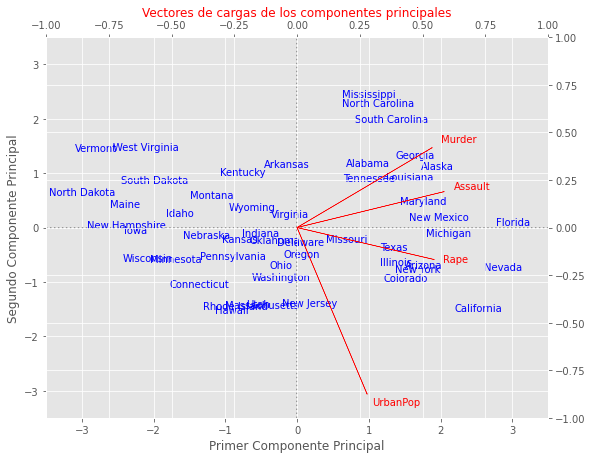

In [15]:
biplot(loadings=pca_loadings, scores=pca_scores, index=df.index, columns=df.columns)

La función `PCA()` también nos brinda la varianza explicada por cada componente principal. Podemos acceder a estos valores como sigue:

In [16]:
explained_variance = pca.explained_variance_

# O, usando SVD:
# explained_variance = (s * s) / X.shape[0]

print('Varianza explicada por cada componente principal:')
print(explained_variance)

Varianza explicada por cada componente principal:
[2.53085875 1.00996444 0.36383998 0.17696948]


También podemos obtener la proporción de varianza explicada por cada componente principal:

In [17]:
PVE = pca.explained_variance_ratio_

# O, lo que es lo mismo:
# PVE = explained_variance / np.sum(explained_variance)

print('Proporción de varianza explicada (PVE) por cada componente principal:')
print(PVE)

Proporción de varianza explicada (PVE) por cada componente principal:
[0.62006039 0.24744129 0.0891408  0.04335752]


Podemos ver que el primer componente principal explica 62.0% de la varianza en los datos, el siguiente componente principal explica el 24.7% de la varianza, y así en adelante. Podemos diagramar la proporción de varianza explicada (PVE) por cada componente, como sigue:

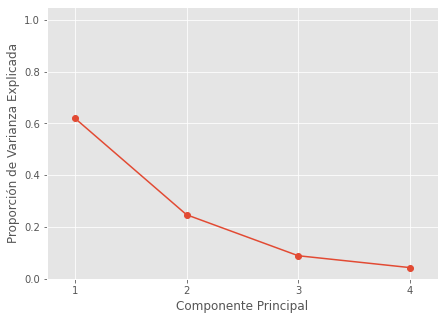

In [18]:
#seleccion de N componentes según análisis tradicional
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4], pca.explained_variance_ratio_, '-o')
plt.ylabel('Proporción de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

También podemos usar la función `numpy.cumsum()`, que calcula la suma acumulada de los elementos de un vector numérico, para diagramar la PVE acumulada:

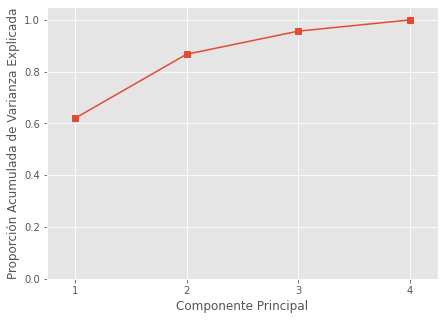

In [19]:
#selección componentes método elbow 
#(note que no es tan curva la funcion dada la poca cantidad de features)
plt.figure(figsize=(7,5))
plt.plot([1,2,3,4], np.cumsum(pca.explained_variance_ratio_), '-s')
plt.ylabel('Proporción Acumulada de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.xlim(0.75,4.25)
plt.ylim(0,1.05)
plt.xticks([1,2,3,4])
plt.show()

# 2. Reducción de dimensionalidad con PCA

(Traducido y adaptado del curso "Machine Learning" de Andrew NG)

En este ejercicio, usarás PCA para realizar reducción de dimensionalidad. Primero experimentarás con un conjunto de datos sencillo en 2D para afianzar la intuición de cómo funciona esta reducción de dimensionalidad, y luego usarás PCA en un conjunto de datos más grande que contiene 5000 rostros.

## 2.1. Conjunto de datos 2D

Empezaremos con un conjunto de datos en 2D que tiene mucha varianza en una dirección y menor variación en la otra. A continuación cargaremos y visualizaremos el conjunto de datos. En esta parte del ejercicio visualizarás lo que ocurre cuando reduces los datos de 2D a 1D. En la práctica, querrás reducir datos de 256 a 50 dimensiones, por decir algo; pero usar datos en menores dimensiones, como en este ejemplo, nos permite visualizar mejor los algoritmos.

In [20]:
!wget 'https://drive.google.com/uc?export=download&id=1Up7hNMhMlzBdDxUJR7l0YbRSM6vB4EYA' -O data1.mat

--2020-10-20 23:33:58--  https://drive.google.com/uc?export=download&id=1Up7hNMhMlzBdDxUJR7l0YbRSM6vB4EYA
Resolving drive.google.com (drive.google.com)... 172.217.214.139, 172.217.214.138, 172.217.214.113, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0g-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a70dcooj04g7tlli6cr9cc6evobvh50d/1603236825000/13307417494834192396/*/1Up7hNMhMlzBdDxUJR7l0YbRSM6vB4EYA?e=download [following]
--2020-10-20 23:33:58--  https://doc-0g-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/a70dcooj04g7tlli6cr9cc6evobvh50d/1603236825000/13307417494834192396/*/1Up7hNMhMlzBdDxUJR7l0YbRSM6vB4EYA?e=download
Resolving doc-0g-3c-docs.googleusercontent.com (doc-0g-3c-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to doc-0g-3c-docs.googleusercontent.com (do

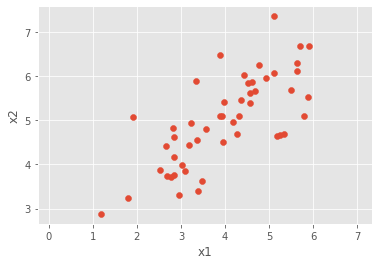

In [21]:
from scipy.io import loadmat
ex7data1 = loadmat('data1.mat')
X = np.array(ex7data1['X'])
plt.axes().set_aspect('equal', 'datalim')
plt.xlabel('x1')
plt.ylabel('x2')
plt.scatter(X[:,0], X[:,1], marker='o', cmap='prism')
plt.show()

Como hemos visto, es importante normalizar primero los datos sustrayendo el valor medio de cada característica del conjunto de datos y escalando cada dimensión para que todas estén en el mismo rango. Es lo que hacemos a continuación:

In [22]:
from sklearn.preprocessing import scale 

X_norm = scale(X)

Veamos cómo los datos se encuentran ahora normalizados:

In [23]:
print('Antes de normalizar:\n', X[:5])
print('\nDespués de normalizar:\n', X_norm[:5])

Antes de normalizar:
 [[3.38156267 3.38911268]
 [4.52787538 5.8541781 ]
 [2.65568187 4.41199472]
 [2.76523467 3.71541365]
 [2.84656011 4.17550645]]

Después de normalizar:
 [[-0.52331306 -1.59279252]
 [ 0.46381518  0.84034523]
 [-1.14839331 -0.58315891]
 [-1.05405373 -1.27071783]
 [-0.98402167 -0.81658417]]


Una vez que los datos están normalizados, puedes ejecutar PCA para calcular los componentes principales. 

In [24]:
pca2 = PCA().fit(X_norm)
pca2_loadings = pca2.components_

print('El vector de cargas del primer componente principal es:')
print(pca2_loadings[0,:])

El vector de cargas del primer componente principal es:
[-0.70710678 -0.70710678]


Grafiquemos la dirección de los dos primeros componentes principales:

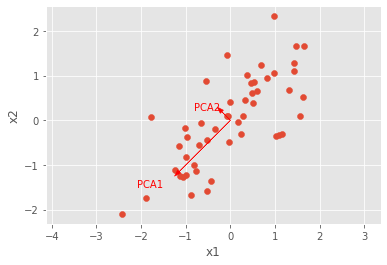

In [25]:
plt.axes().set_aspect('equal', 'datalim')
plt.scatter(X_norm[:,0], X_norm[:,1], marker='o', cmap='prism')
plt.xlabel('x1')
plt.ylabel('x2')
a = 1.2
plt.annotate('PCA1', (pca2_loadings[0,0]*pca2.explained_variance_[0]*a, pca2_loadings[0,1]*pca2.explained_variance_[0]*a), color='red', ha='right')
plt.arrow(0,0, pca2_loadings[0,0]*pca2.explained_variance_[0], pca2_loadings[0,1]*pca2.explained_variance_[0], color='r', head_width=0.1, length_includes_head=True)
plt.annotate('PCA2', (pca2_loadings[1,0]*pca2.explained_variance_[1]*a, pca2_loadings[1,1]*pca2.explained_variance_[1]*a), color='red', ha='right')
plt.arrow(0,0, pca2_loadings[1,0]*pca2.explained_variance_[1], pca2_loadings[1,1]*pca2.explained_variance_[1], color='r', head_width=0.1, length_includes_head=False)
plt.show()

## 2.2. Proyección de los datos sobre los componentes principales

Después de calcular los componentes principales, puedes usarlos para reducir la dimensión de características de tu conjunto de datos proyectando cada ejemplo sobre un espacio de menores dimensiones, $x^{(i)} \rightarrow z^{(i)}$ (p.ej., proyectando los datos de 2D a 1D).

En la práctica, si estuvieses usando un algoritmo de aprendizaje tal como regresión lineal o quizás redes neuronales, podrías usar los datos proyectados en lugar de los datos originales. Usando los datos proyectados, puedes entrenar tu modelo más rápido pues hay menos dimensiones en los datos de entrada.

Para proyectar los datos sólo necesitas truncar las primeras `K` columnas de la matriz de puntajes.

In [26]:
def projectData(pcaModel, X, K):
    Z = pcaModel.transform(X)[:,:K]
    return Z

In [27]:
# Proyectamos los datos
Z = projectData(pca2, X_norm, 1)

print('La proyección del primer ejemplo sobre la primera dimensión es: %0.5f' % Z[0,0])

La proyección del primer ejemplo sobre la primera dimensión es: 1.49631


## 2.3. Reconstrucción de una aproximación de los datos

Luego de proyectar los datos en un espacio de menores dimensiones, puedes recuperar aproximadamente los datos proyectándolos de regreso en el espacio original de alta dimensión. Para hacerlo, multiplicamos Z por las primeras `K` filas de la matriz de carga.

In [28]:
def recoverData(pcaModel, Z):
    K = Z.shape[1]
    X_rec = np.dot(Z, pcaModel.components_[:K,:])
    return X_rec

In [29]:
X_rec = recoverData(pca2, Z)

## 2.4. Visualización de las proyecciones

Una vez realizada la proyección y reconstrucción aproximada de los datos, veamos en el siguiente diagrama cómo la proyección afecta los datos. Los puntos de datos originales están indicados con color azul, mientras que los puntos de datos proyectados están indicados con color rojo. La proyección retiene efectivamente la información en la dirección del primer componente principal.

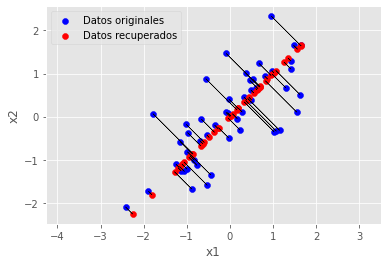

In [30]:
plt.axes().set_aspect('equal', 'datalim')
for i in range(X_norm.shape[0]):
    plt.arrow(X_norm[i,0], X_norm[i,1], X_rec[i,0]-X_norm[i,0], X_rec[i,1]-X_norm[i,1], color='k')
plt.scatter(X_norm[:,0], X_norm[:,1], marker='o', c='blue', label='Datos originales')  
plt.scatter(X_rec[:,0], X_rec[:,1], marker='o', c='red', label='Datos recuperados')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(loc='upper left')
plt.show()

#los puntos en rojos son los datos recuperdos luego de la proyección en 1 dimension

## 2.5. Conjunto de datos de imágenes de rostros

En esta parte del ejercicio, aplicarás PCA a imágenes de rostros para ver cómo puede se puede usar PCA en la práctica para reducción de la dimensionalidad. El archivo `faces.mat` contiene un conjunto de datos `X` con imagénes de 32 x 32 pixeles en tonos de grises. Cada fila corresponde a una imagen (un vector fila de longitud 1024). En el siguiente paso cargaremos `X` y visualizaremos las primeras 100 imágenes.

In [31]:
!wget 'https://drive.google.com/uc?export=download&id=1Bxtbq_L3RCGWDT0cQCQe_7TZdUYY5Am_' -O faces.mat

--2020-10-20 23:33:59--  https://drive.google.com/uc?export=download&id=1Bxtbq_L3RCGWDT0cQCQe_7TZdUYY5Am_
Resolving drive.google.com (drive.google.com)... 172.217.214.139, 172.217.214.113, 172.217.214.102, ...
Connecting to drive.google.com (drive.google.com)|172.217.214.139|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rfdehp306ibj14ggcqttgc9hlqspa4ag/1603236825000/13307417494834192396/*/1Bxtbq_L3RCGWDT0cQCQe_7TZdUYY5Am_?e=download [following]
--2020-10-20 23:34:01--  https://doc-0o-3c-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/rfdehp306ibj14ggcqttgc9hlqspa4ag/1603236825000/13307417494834192396/*/1Bxtbq_L3RCGWDT0cQCQe_7TZdUYY5Am_?e=download
Resolving doc-0o-3c-docs.googleusercontent.com (doc-0o-3c-docs.googleusercontent.com)... 74.125.124.132, 2607:f8b0:4001:c14::84
Connecting to doc-0o-3c-docs.googleusercontent.com (do

In [32]:
from scipy.io import loadmat

ex7faces = loadmat('faces.mat')
X = np.array(ex7faces['X'])

In [33]:
from matplotlib.pyplot import figure, imshow, axis

def mostrarImagenes(X, num_cols, shape, title='asdf'):
    num_imagenes = X.shape[0]
    num_filas = np.ceil(num_imagenes / num_cols)
    fig = figure()
    fig.set_size_inches(10, 10)

    for i in range(num_imagenes):
        a=fig.add_subplot(num_filas, num_cols, i +1)
        image = X[i,:].reshape(shape).T
        imshow(image,cmap='Greys_r')
        axis('off')

Imágenes originales


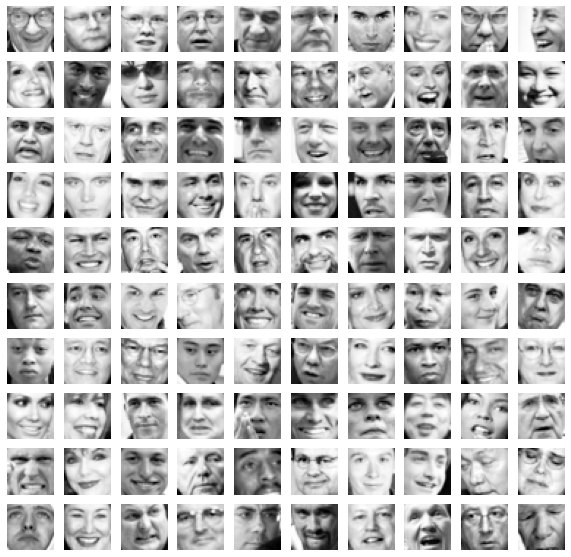

In [34]:
print('Imágenes originales')
mostrarImagenes(X[:100], 10, [32, 32])

### 2.5.1. PCA en rostros 

Antes de ejecutar PCA en el conjunto de datos, normaliza el conjunto de datos usando la función `scale`. Luego ajusta un modelo PCA a los datos. Observa que cada fila de la matriz de cargas es un vector de longitud $n$ (para el dataset, $n = 1024$). Resulta que podemos visualizar estos componentes principales transformando cada uno de ellos en una matriz 32 x 32 que corresponde a los pixeles del conjunto de datos original. Una vez que hayas ajustado el modelo PCA, mostraremos los primeros 36 componentes principales que describen la mayor varianza. Si deseas, modifica el código para mostrar más componentes principales y ver cómo capturan cada vez más detalles.

In [35]:
from sklearn.preprocessing import scale 

X_norm = scale(X)
pca_faces = PCA().fit(X_norm)
pca_faces_loadings = pca_faces.components_

Carga de los primeros 36 componentes principales


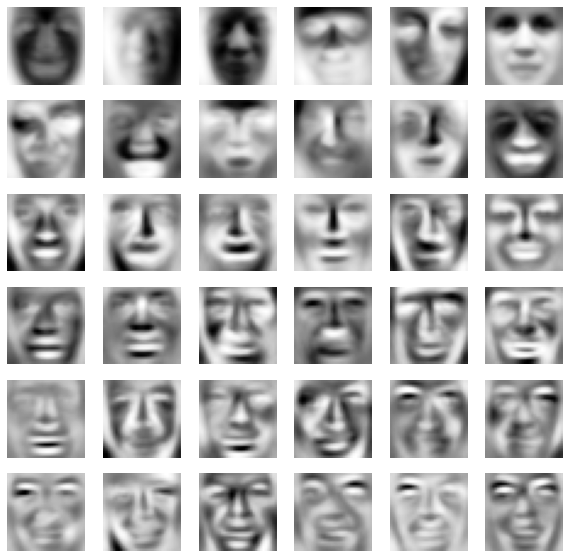

In [36]:
print('Carga de los primeros 36 componentes principales')
mostrarImagenes(pca_faces_loadings[:36,:], num_cols=6, shape=[32, 32])

## TAREA


### **Tarea clase 5:** Reducción de dimensionalidad

Ahora que has calculado los principales componentes del conjunto de datos de rostros, puedes usarlos para reducir su dimensionalidad. Esto te permite entrenar tu algoritmo de aprendizaje con un tamaño de entradas menor (p.ej., 100 dimensiones) en lugar de las 1024 dimensiones originales. Esto puede ayudar a acelerar tu algoritmo de aprendizaje.

En la siguiente parte proyectarás el conjunto de datos sobre solamente los primeros 100 componentes principales. Específicamente, cada imagen quedará descrita por un vector $z^{(i)} \in \mathbb{R}^{100}$.

Para entender lo que se pierde en la reducción de dimensionalidad, recuperarás las imágenes a partir de los datos proyectados.

Una vez que hayas calculado las proyecciones y la recuperación de los datos, visualizaremos las imágenes reconstruidas. En la reconstrucción podrás observar que se conserva la estructura general y apariencia de los rostros, y se pierde los detalles más finos. Esta es una notable reducción (más de 10x) en el tamaño del conjunto de datos, que puede ayudar a acelerar significativamente tu algoritmo de aprendizaje. Por ejemplo, si estuvieses entrenando una red neuronal para realizar reconocimiento de personas (dada la imagen de un rostro, identificar a la persona), puedes usar la entrada reducida a 100 dimensiones en lugar de los pixeles originales.

In [46]:
# Proyecta los datos sobre los primeros 100 componentes principales
# Completar...
proyected_faces = projectData(pca_faces, X_norm, 100)
# Recupera los datos a partir de la proyección
# Completar...
X_rec_faces = recoverData(pca_faces, proyected_faces)

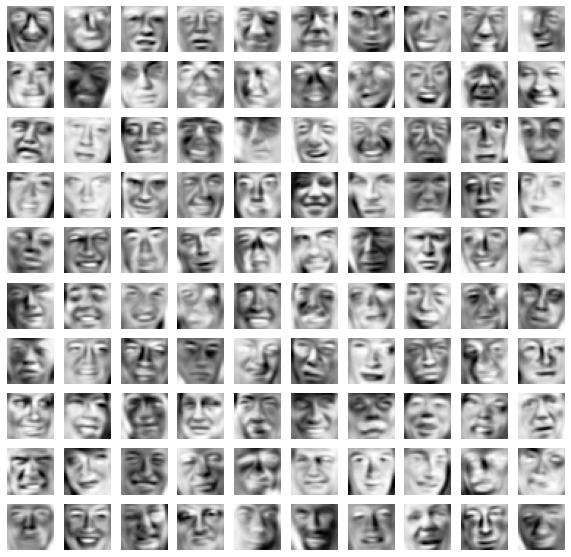

In [47]:
#visualización:
# imágenes org. reconstruidas con el PCA previo
# proyección de las imágenes originales sobre los 100 componentes princ.
mostrarImagenes(X_rec_faces[:100], 10, [32, 32])

¿Cuál es la proporción acumulada de varianza explicada por los primeros 100 componentes principales del conjunto de datos de rostros? (Redondear a 4 decimales)

In [80]:
# Completar...
pve_faces = pca_faces.explained_variance_ratio_[:100]

cumsum_pvefaces = np.cumsum(pve_faces)

# O, lo que es lo mismo:
# PVE = explained_variance / np.sum(explained_variance)
pve_firstn = (pve_faces/ cumsum_pvefaces)

print('Proporción de varianza explicada (PVE) para los 100 componente principales:')
print(pve_firstn)

Proporción de varianza explicada (PVE) para los 100 componente principales:
[1.00000000e+00 2.79805386e-01 1.04645102e-01 7.06450872e-02
 5.56840306e-02 3.70231249e-02 3.18185174e-02 2.94982681e-02
 2.37019896e-02 2.13439790e-02 1.92455427e-02 1.80243841e-02
 1.45821209e-02 1.28213866e-02 1.13832520e-02 1.12063498e-02
 9.72249571e-03 9.24132501e-03 8.78536389e-03 8.35032133e-03
 7.14188751e-03 6.93894722e-03 6.73998232e-03 6.44029666e-03
 6.20425486e-03 5.94768324e-03 5.88432251e-03 5.48867172e-03
 5.24965236e-03 5.07922719e-03 4.84457113e-03 4.68748576e-03
 4.34700422e-03 4.19308265e-03 4.09201064e-03 3.79379615e-03
 3.72522321e-03 3.64779347e-03 3.55925270e-03 3.39785294e-03
 3.32430169e-03 3.22238461e-03 3.04587315e-03 2.98661177e-03
 2.96195402e-03 2.83562385e-03 2.72502251e-03 2.65347924e-03
 2.59137658e-03 2.48526634e-03 2.42374262e-03 2.30604878e-03
 2.27662048e-03 2.21988186e-03 2.18653701e-03 2.10231224e-03
 2.05913289e-03 1.99200392e-03 1.96716335e-03 1.94430593e-03
 1.882586

¿Puedes graficar la proporción acumulada de varianza explicada por PCA para este conjunto de datos?

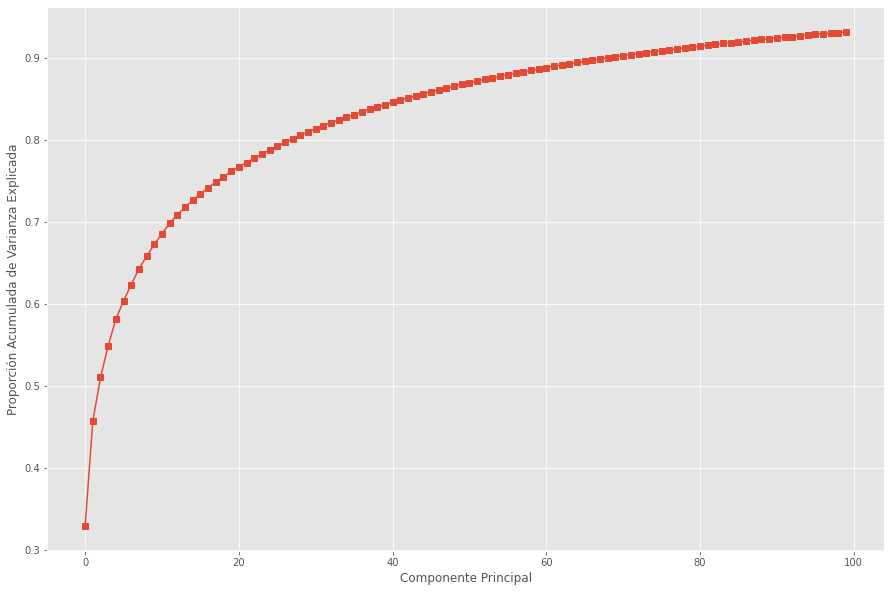

In [81]:
# Completar... #acá va el elbow
plt.figure(figsize=(15,10))
plt.plot(cumsum_pvefaces, '-s')
plt.ylabel('Proporción Acumulada de Varianza Explicada')
plt.xlabel('Componente Principal')
plt.show()